In [2]:
import numpy as np
import pandas as pd
import pathlib
from price_utils import check_dependency
import datetime as dt
import matplotlib.pyplot as plt
import calendar

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 50)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [3]:
pathlib.Path.cwd()
data_path = pathlib.Path("../../../data")
df1 = pd.read_csv(data_path/"raw/hurb_sales_v1.csv")
df2 = pd.read_csv(data_path/"processed/hurb_sales_flexible_v2.csv") #usando só as datas flexíveis
df_history = pd.read_csv(data_path/"raw/hurb_active_history.csv")

In [143]:
df_history.columns

Index(['ingestion_time', 'sku', 'online'], dtype='object')

In [4]:
df2.shape

(622234, 36)

In [3]:
df1.shape

(644550, 25)

In [4]:
df1.head(5)

,ingestion_time,package_id,offer_option_id,sku,first_price,discounted_price,tax,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,destination_type,fullprice,discount,interest,totalprice,sales
0,2022-01-07,848345,2393090,LGPKG-848345-2393090,449,998,50.0,694.0,19.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",Aéreo de São Paulo - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN
1,2022-01-07,848345,2393091,LGPKG-848345-2393091,449,998,50.0,694.0,11.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",Aéreo de Rio de Janeiro - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN
2,2022-01-07,848345,2393092,LGPKG-848345-2393092,722,1618,NaN,694.0,3.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",Aéreo de Brasília - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN
3,2022-01-07,848345,2393096,LGPKG-848345-2393096,674,1498,75.0,694.0,1.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",G: Aéreo de Vitória - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN
4,2022-01-07,848345,2393097,LGPKG-848345-2393097,833,1858,NaN,694.0,NaN,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",H: Aéreo de Salvador - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN


In [72]:
## 1. drop lines with nan which include true, full, discount, tax
## 2. create a column trueprice = fullprice - discount + tax
## 3. calculate differences in trueprice for a given id

In [86]:
def process_option(df_option):
    hist_option = df_history[df_history.sku==df_option.sku.iloc[0]]
    df_new = df_option.sort_values(by=["ingestion_time", "datebr"]).reset_index(drop=True)
    df_new.loc[df_new.datebr.isna(), ("datebr") ] = df_new.loc[df_new.datebr.isna(), ("ingestion_time")]
    price_columns=["fullprice", "tax", "discount", "totalprice"]
    df_new[price_columns] = df_new[price_columns].interpolate(method="pad")
    df_new.loc[df_new.sales.isna(), ("sales", "interest")] = 0.0
    df_new["trueprice"] = df_new.fullprice - df_new.discount + df_new.tax
    df_new["online"] = df_new["ingestion_time"].apply( lambda x: hist_option.online[hist_option["ingestion_time"]==x].max() )
    return df_new

In [87]:
df_example = process_option(df2[df2.sku=="LGPKG-1138711-2776691"])

In [91]:
##Agora nao tem nenhum nan pq interpolou:
df_example.isna().sum()

ingestion_time                     0
package_id                         0
offer_option_id                    0
sku                                0
discounted_price                   0
package_clicks                     0
offer_checkout                     6
multidestino                       0
year                               0
package_date_format                0
destination_city                   0
destination_state                  0
destination_country                0
AttributeList                      0
offer_option_title                 0
offer_option_description           0
product_name                       0
qty_dailies                        0
option_cost                        0
origin_city                        0
all_inclusive_included_in_offer    0
breakfast_included_in_offer        0
transfer_included_in_offer         0
ticket_included_in_offer           0
tour_included_in_offer             0
bus_included_in_offer              0
car_included_in_offer              0
c

In [94]:
## Agora náo tem nan mas sao todos do mesmo sku
df_example["sku"].value_counts()

LGPKG-1138711-2776691    481
Name: sku, dtype: int64

In [97]:
df_example.columns

Index(['ingestion_time', 'package_id', 'offer_option_id', 'sku',
       'discounted_price', 'package_clicks', 'offer_checkout', 'multidestino',
       'year', 'package_date_format', 'destination_city', 'destination_state',
       'destination_country', 'AttributeList', 'offer_option_title',
       'offer_option_description', 'product_name', 'qty_dailies',
       'option_cost', 'origin_city', 'all_inclusive_included_in_offer',
       'breakfast_included_in_offer', 'transfer_included_in_offer',
       'ticket_included_in_offer', 'tour_included_in_offer',
       'bus_included_in_offer', 'car_included_in_offer',
       'cruise_included_in_offer', 'destination_type', 'datebr', 'fullprice',
       'tax', 'discount', 'interest', 'totalprice', 'sales', 'trueprice',
       'online'],
      dtype='object')

In [98]:
## Create column with trueprice
df_example['trueprice'] = df_example['fullprice'] - df_example['discount'] + df_example['tax']

In [99]:
df_example.head(3)

,ingestion_time,package_id,offer_option_id,sku,discounted_price,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,qty_dailies,option_cost,origin_city,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,destination_type,datebr,fullprice,tax,discount,interest,totalprice,sales,trueprice,online
0,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-01,998.0,80.0,216.0,0.0,863.0,4.0,862.0,1
1,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-02,998.0,80.0,216.0,0.0,863.0,10.0,862.0,1
2,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-02,998.0,80.0,216.0,690.0,1553.0,1.0,862.0,1


In [101]:
##Calculate differences in trueprice
deltas = np.diff(df_example['trueprice'])

In [104]:
len(deltas)

480

In [110]:
##Add zero in the end in order to match the index:
deltas = np.append(deltas, 0)

In [108]:
len(deltas)

481

In [103]:
df_example.shape

(481, 38)

In [109]:
##Create column with that variation
df_example['price_variation'] = deltas

In [111]:
df_example.head()

,ingestion_time,package_id,offer_option_id,sku,discounted_price,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,qty_dailies,option_cost,origin_city,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,destination_type,datebr,fullprice,tax,discount,interest,totalprice,sales,trueprice,online,price_variation
0,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-01,998.0,80.0,216.0,0.0,863.0,4.0,862.0,1,0.0
1,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-02,998.0,80.0,216.0,0.0,863.0,10.0,862.0,1,0.0
2,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-02,998.0,80.0,216.0,690.0,1553.0,1.0,862.0,1,0.0
3,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-03,998.0,80.0,216.0,0.0,863.0,18.0,862.0,1,0.0
4,2022-01-07,1138711,2776691,LGPKG-1138711-2776691,998,2157.0,113.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de São Paulo - 4 diárias,Aéreo para Buenos Aires | 4 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,4,2783,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-04,998.0,80.0,216.0,414.0,1277.0,2.0,862.0,1,0.0


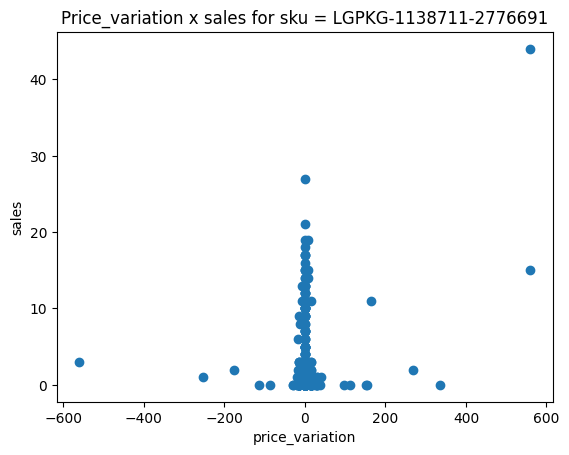

In [116]:
plt.scatter(df_example['price_variation'], df_example['sales'])
plt.xlabel('price_variation')
plt.ylabel('sales')
plt.title('Price_variation x sales for sku = LGPKG-1138711-2776691')
plt.show()

In [132]:
df_example['sales'].corr(df_example['price_variation'])

0.2648880657646947

In [133]:
df_example['price_variation'].corr(df_example['sales'])

0.2648880657646947

In [134]:
#### Making a function for everything above:
def scatter_price_var(df, sku):
    df_example = process_option(df[df.sku==sku])
    df_example['trueprice'] = df_example['fullprice'] - df_example['discount'] + df_example['tax']
    deltas = np.diff(df_example['trueprice'])
    deltas = np.append(deltas, 0)
    df_example['price_variation'] = deltas
    plt.scatter(df_example['price_variation'], df_example['sales'])
    plt.xlabel('price_variation')
    plt.ylabel('sales')
    plt.title(f'Price_variation x sales for sku = {sku}')
    plt.show()    
    print(f"The correlation between sales and price_variation is {df_example['sales'].corr(df_example['price_variation'])}.")

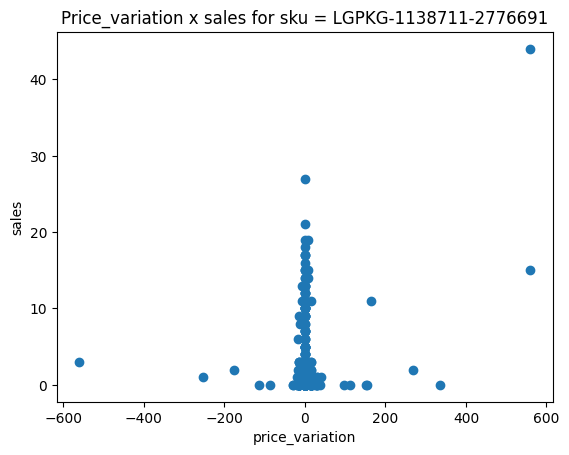

The correlation between sales and price_variation is 0.2648880657646947.


In [135]:
scatter_price_var(df2, "LGPKG-1138711-2776691")

In [127]:
## Vou fazer isso para o sku que mais vende (que é o Pacote de Viagem - Natal - All Inclusive - 2024)

In [121]:
df2.groupby('sku').sum()['sales']

/var/folders/zz/zyxvpxvq6csfxvn_n0000qnh0005xc/T/ipykernel_4174/1485209328.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby('sku').sum()['sales']


sku
LGPKG-1089491-2708005    457.0
LGPKG-1089491-2708006    560.0
LGPKG-1089494-2708121    834.0
LGPKG-1089494-2708122     72.0
LGPKG-1089494-2708123    835.0
                         ...  
LGPKG-873073-2466796       2.0
LGPKG-873073-2466797       1.0
LGPKG-873073-2466799       0.0
LGPKG-873073-2466800      11.0
LGPKG-873073-2466801       0.0
Name: sales, Length: 4412, dtype: float64

In [122]:
df2.groupby('sku').sum()['sales'].idxmax()

/var/folders/zz/zyxvpxvq6csfxvn_n0000qnh0005xc/T/ipykernel_4174/4238618109.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby('sku').sum()['sales'].idxmax()


'LGPKG-1407683-3070778'

In [126]:
df2[df2['sku']=="LGPKG-1407683-3070778"]

,ingestion_time,package_id,offer_option_id,sku,discounted_price,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,qty_dailies,option_cost,origin_city,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,destination_type,datebr,fullprice,tax,discount,interest,totalprice,sales
344817,2022-09-23,1407683,3070778,LGPKG-1407683-3070778,1799,143.0,7.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347140,2022-09-24,1407683,3070778,LGPKG-1407683-3070778,1799,153.0,15.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347392,2022-09-25,1407683,3070778,LGPKG-1407683-3070778,1799,247.0,22.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350337,2022-09-26,1407683,3070778,LGPKG-1407683-3070778,1799,605.0,68.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352286,2022-09-27,1407683,3070778,LGPKG-1407683-3070778,1799,1092.0,73.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603060,2022-12-30,1407683,3070778,LGPKG-1407683-3070778,1798,1402.0,86.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,2022-12-30,1798.0,0.0,0.0,216.0,2014.0,1.0
604909,2022-12-31,1407683,3070778,LGPKG-1407683-3070778,1798,1008.0,73.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 Diárias | All Inclusive,Pacote de Viagem - Natal - All Inclusive - 2024,5,2214,São Paulo,True,False,False,False,False,False,False,False,NAC,2022-12-31,1798.0,0.0,0.0,324.0,2122.0,2.0
608267,2022-10-19,1407683,3070778,LGPKG-1407683-3070778,1799,826.0,58.0,False,2024.0,Data flexível,Natal,Rio Grande do Norte,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Natal | Quarto Duplo ou Triplo | 5 D

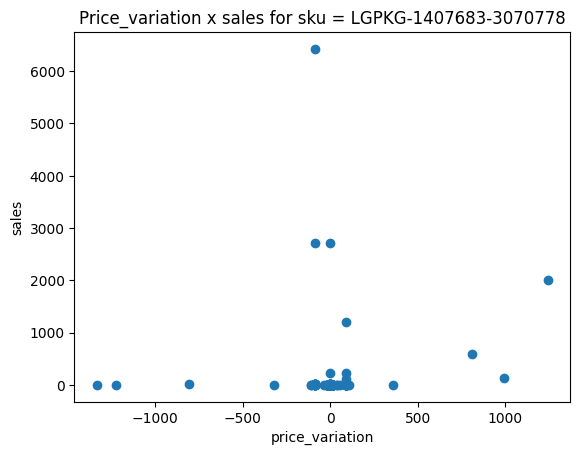

The correlation between sales and price_variation is 0.11216360446056932.


In [136]:
scatter_price_var(df2, "LGPKG-1407683-3070778")

In [76]:
df2.head()

,ingestion_time,package_id,offer_option_id,sku,discounted_price,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,qty_dailies,option_cost,origin_city,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,destination_type,datebr,fullprice,tax,discount,interest,totalprice,sales
0,2022-01-07,1138711,2776698,LGPKG-1138711-2776698,3536,2157.0,1.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de Brasília - 6 diárias,Aéreo para Buenos Aires | 6 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,6,3317,Brasília,False,False,False,False,False,False,False,False,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-07,1100870,2730806,LGPKG-1100870-2730806,7373,226.0,8.0,True,2022.0,Data flexível,Roma + Paris + Amsterdam,Lazio,Itália,"Hospedagem Econômica,Passagem Aérea Econômica",Aéreo de São Paulo - 6 diárias inclusas + 3 diárias GRÁTIS,Aéreo de ida e volta | Quarto Duplo ou Triplo | 9 Diárias (6 Diárias Inclusas + 1 Diária Grátis em Cada Destino) | 03 Diárias em Roma + 03 Diárias em Paris + 03 Diárias em Amsterdam.,Pacote de Viagem - Roma + Paris + Amsterdam com Diárias Grátis - 2022,9,5776,São Paulo,False,False,False,False,False,False,False,False,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-07,1141944,2782951,LGPKG-1141944-2782951,1123,4903.0,8.0,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Café da manhã,Passagem Aérea Econômica,Hospedagem Econômica,Passeio",Aéreo de Cuiabá,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 5 Diárias (3 diárias em Caxias do Sul + 2 diárias em Gramado ou Canela) | Passeio a Casa Perini,Pacote de Viagem - Serra Gaúcha (Caxias do Sul + Gramado ou Canela) - 2023,5,1264,Cuiabá,False,True,False,False,True,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-07,1137691,2775414,LGPKG-1137691-2775414,498,NaN,12.0,False,2022.0,Data flexível,Belo Horizonte,Minas Gerais,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro - 2 diárias,Aéreo para Belo Horizonte | 2 Diárias em Quarto Duplo ou Triplo,Pacote de Viagem - Belo Horizonte (Minas Gerais) - 2022,2,375,Rio de Janeiro,False,True,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-07,1104605,2734845,LGPKG-1104605-2734845,2998,354.0,11.0,False,2022.0,Data flexível,Ilhéus,Bahia,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo - 5 diárias,Aéreo para Ilhéus| 5 Diárias em Quarto Duplo ou Triplo.\r\n,Pacote de Viagem - Ilhéus - All Inclusive - 2022,5,2325,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
## o v2 tá melhor que o nan
df2.isna().sum()/df2.shape[0]

ingestion_time                     0.000000
package_id                         0.000000
offer_option_id                    0.000000
sku                                0.000000
discounted_price                   0.000000
package_clicks                     0.081176
offer_checkout                     0.415009
multidestino                       0.000000
year                               0.005789
package_date_format                0.000000
destination_city                   0.001986
destination_state                  0.004632
destination_country                0.001986
AttributeList                      0.000000
offer_option_title                 0.000000
offer_option_description           0.000000
product_name                       0.000000
qty_dailies                        0.000000
option_cost                        0.000000
origin_city                        0.002948
all_inclusive_included_in_offer    0.000000
breakfast_included_in_offer        0.000000
transfer_included_in_offer      

In [77]:
## Tem muito nan no v1:
df1.isna().sum()/df1.shape[0]

ingestion_time              0.000000
package_id                  0.000000
offer_option_id             0.000000
sku                         0.000000
first_price                 0.000000
discounted_price            0.000000
tax                         0.164208
package_clicks              0.053526
offer_checkout              0.433402
multidestino                0.000000
year                        0.005394
package_date_format         0.000000
destination_city            0.001519
destination_state           0.003815
destination_country         0.001519
AttributeList               0.000000
offer_option_title          0.000000
offer_option_description    0.000000
product_name                0.000000
destination_type            0.000000
fullprice                   0.979027
discount                    0.979027
interest                    0.979027
totalprice                  0.979027
sales                       0.979027
dtype: float64

I'm trying to answer the following question: how sales behave with day week? Which day sales the most? In order to do this, i'll have to convert the dates into days.

In [5]:
#Add a column with week day
week_day = []
for i in range (df1.shape[0]): 
    date = pd.Timestamp(df1.iloc[i,0])
    week_day.append(date.day_name())
df1['Week day'] = week_day
df1.head()

,ingestion_time,package_id,offer_option_id,sku,first_price,discounted_price,tax,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,destination_type,fullprice,discount,interest,totalprice,sales,Week day
0,2022-01-07,848345,2393090,LGPKG-848345-2393090,449,998,50.0,694.0,19.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",Aéreo de São Paulo - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN,Friday
1,2022-01-07,848345,2393091,LGPKG-848345-2393091,449,998,50.0,694.0,11.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",Aéreo de Rio de Janeiro - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN,Friday
2,2022-01-07,848345,2393092,LGPKG-848345-2393092,722,1618,NaN,694.0,3.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",Aéreo de Brasília - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN,Friday
3,2022-01-07,848345,2393096,LGPKG-848345-2393096,674,1498,75.0,694.0,1.0,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",G: Aéreo de Vitória - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN,Friday
4,2022-01-07,848345,2393097,LGPKG-848345-2393097,833,1858,NaN,694.0,NaN,False,2022.0,Data flexível,Balneário Camboriú,Santa Catarina,Brasil,"Hospedagem Econômica,Café da manhã,City Tour,Passagem Aérea Econômica",H: Aéreo de Salvador - 5 diárias + City Tour Blumenau,Aéreo para Balneário Camboriú | Quarto duplo ou Triplo | City Tour Blumenau.,Pacote de Viagem - Balneário Camboriú + City Tour Blumenau - 2022,NAC,NaN,NaN,NaN,NaN,NaN,Friday


In [6]:
df1['Week day'].value_counts()

Tuesday      98598
Wednesday    97736
Friday       93636
Thursday     92392
Monday       90412
Saturday     88246
Sunday       83530
Name: Week day, dtype: int64

The pie chart below show that sales is approximately well distributed along the week. The day with most sales is Thursday followed by sunday.

<Axes: ylabel='sales'>

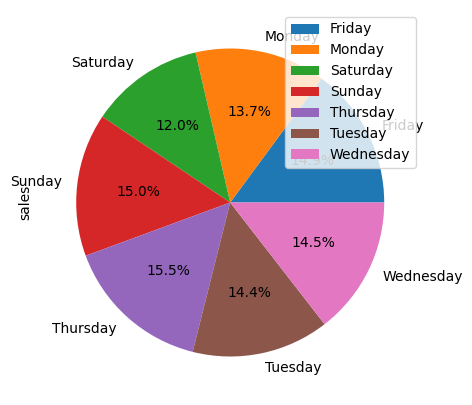

In [7]:
t = df1.groupby(['Week day']).sum(['sales'])
plot2 = t.plot.pie(y='sales', figsize=(5, 5), autopct='%1.1f%%')
plot2

In [8]:
## I'm trying to answer the following question: how sales behave with day of month? Which day sales the most?

In [11]:
#Add column with days
day = []
for i in range (df1.shape[0]): 
    date = pd.Timestamp(df1.iloc[i,0])
    day.append(date.to_pydatetime().day)
df1['day'] = day

In [31]:
u['sales'].idxmax()

27

## The day with most sales is 27 in v1:

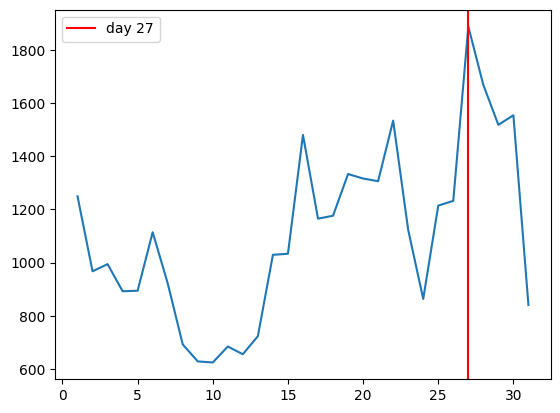

In [34]:
plt.plot(u['sales'])
plt.axvline(x=u['sales'].idxmax(), color = 'r', label = 'day 27')
plt.legend()
plt.show()

## The day with most sales in v2

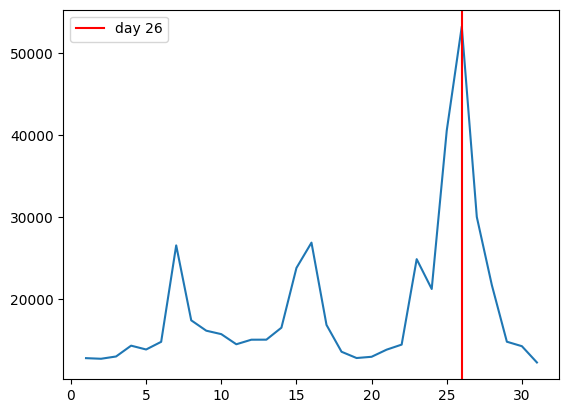

In [49]:
#Add column with days
day2 = []
for i in range (df2.shape[0]): 
    date = pd.Timestamp(df2.iloc[i,0])
    day2.append(date.to_pydatetime().day)
df2['day'] = day2
u2 = df2.groupby(['day']).sum(['sales'])

plt.plot(u2['sales'])
plt.axvline(x=u2['sales'].idxmax(), color = 'r', label = 'day 26')
plt.legend()
plt.show()

In [48]:
u2['sales'].idxmax()

26

<Axes: ylabel='sales'>

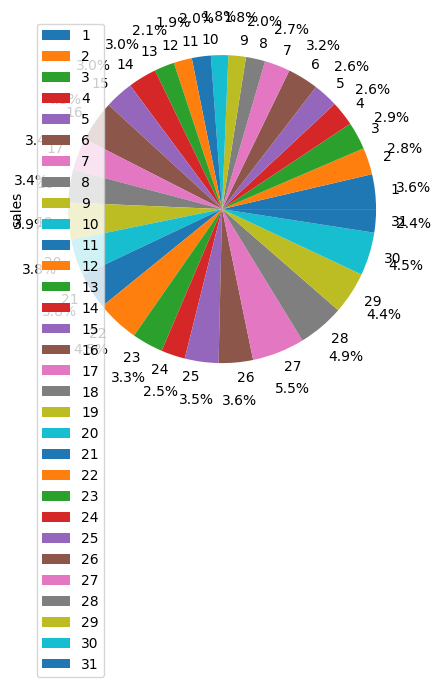

In [13]:
##Plotting a pie chart
u = df1.groupby(['day']).sum(['sales'])
plot1 = u.plot.pie(y='sales', figsize=(5, 5), autopct='%1.1f%%', pctdistance=1.25)
plot1

In [47]:
## Trying to understand if the variation in price affects sales. 
## Does a big variation in price represents a big variation in sales?

In [36]:
o = dict(df1['offer_option_id'].value_counts())

In [37]:
len(o)

5088

In [38]:
ids = list(o.keys())

In [56]:
price_var_total = []
total_sales = []
for i in ids:
    df2 = df1[df1['offer_option_id'] == i]
    price_var2 = df2['totalprice'].max() - df2['totalprice'].min()
    total_sales2 = df2['sales'].sum()
    price_var_total.append(price_var2)
    total_sales.append(total_sales2)

In [57]:
novo_df = pd.DataFrame({'offer_id': ids, 'total_sales' : total_sales, 'price_var_total' : price_var})

In [58]:
price_var_disc = []
for i in ids:
    df2 = df1[df1['offer_option_id'] == i]
    price_var2_disc = df2['discounted_price'].max() - df2['discounted_price'].min()
#    total_sales2 = df2['sales'].sum()
    price_var_disc.append(price_var2_disc)
#    total_sales.append(total_sales2)

In [59]:
novo_df['price_var_disc']= price_var_disc

In [60]:
novo_df.head()

,offer_id,total_sales,price_var_total,price_var_disc
0,2781871,26.0,1050.0,3701
1,2777019,4.0,0.0,1776
2,2780439,3.0,12.0,1000
3,2786346,16.0,606.0,726
4,2779315,9.0,220.0,4368


In [62]:
novo_df['price_var_disc'].idxmax()

2301

In [63]:
novo_df.iloc[novo_df['price_var_disc'].idxmax(),0]

3043759

In [64]:
df1[df1['offer_option_id']==3043759]

,ingestion_time,package_id,offer_option_id,sku,first_price,discounted_price,tax,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,destination_type,fullprice,discount,interest,totalprice,sales,Week day,day
260464,2022-07-27,1395057,3043759,LGPKG-1395057-3043759,899999,999999,99999.0,2.0,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Wednesday,27
264398,2022-07-29,1395057,3043759,LGPKG-1395057-3043759,499,748,74.0,35.0,1.0,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Friday,29
266218,2022-07-30,1395057,3043759,LGPKG-1395057-3043759,499,748,74.0,1.0,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Saturday,30
270677,2022-08-01,1395057,3043759,LGPKG-1395057-3043759,499,748,74.0,NaN,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Monday,1
274548,2022-08-03,1395057,3043759,LGPKG-1395057-3043759,8999999,9999999,999999.0,NaN,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Wednesday,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603767,2022-12-20,1395057,3043759,LGPKG-1395057-3043759,499,748,150.0,2.0,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Tuesday,20
607321,2022-12-21,1395057,3043759,LGPKG-1395057-3043759,499,748,150.0,2.0,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Wednesday,21
610546,2022-12-22,1395057,3043759,LGPKG-1395057-3043759,499,748,150.0,1.0,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Thursday,22
613677,2022-12-23,1395057,3043759,LGPKG-1395057-3043759,499,748,150.0,NaN,NaN,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 4 Diárias,Pacote de Viagem - Gramado ou Canela - 2023,NAC,NaN,NaN,NaN,NaN,NaN,Friday,23


In [51]:
novo_df['price_var'].value_counts()

0.0       1047
220.0       11
1.0          7
342.0        7
226.0        7
          ... 
225.0        1
366.0        1
1177.0       1
1034.0       1
181.0        1
Name: price_var, Length: 437, dtype: int64

In [52]:
novo_df['price_var'].max()

4968.0

In [53]:
novo_df.iloc[novo_df['price_var'].idxmax(),0]

2773706

In [55]:
df1[df1['offer_option_id']==2773706]

,ingestion_time,package_id,offer_option_id,sku,first_price,discounted_price,tax,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,destination_type,fullprice,discount,interest,totalprice,sales,Week day,day
505,2022-01-07,1136305,2773706,LGPKG-1136305-2773706,2699,3498,385.0,401.0,23.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,NaN,NaN,NaN,NaN,NaN,Friday,7
1878,2022-01-08,1136305,2773706,LGPKG-1136305-2773706,2699,3498,385.0,392.0,23.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,NaN,NaN,NaN,NaN,NaN,Saturday,8
3085,2022-01-09,1136305,2773706,LGPKG-1136305-2773706,2699,3498,385.0,829.0,38.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,NaN,NaN,NaN,NaN,NaN,Sunday,9
4361,2022-01-10,1136305,2773706,LGPKG-1136305-2773706,2699,3498,385.0,727.0,47.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,NaN,NaN,NaN,NaN,NaN,Monday,10
5639,2022-01-11,1136305,2773706,LGPKG-1136305-2773706,2699,3498,385.0,600.0,39.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,NaN,NaN,NaN,NaN,NaN,Tuesday,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629346,2022-12-28,1136305,2773706,LGPKG-1136305-2773706,5589,3599,NaN,1213.0,127.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,3599.0,0.0,0.0,3599.0,2.0,Wednesday,28
632482,2022-12-29,1136305,2773706,LGPKG-1136305-2773706,5589,3599,NaN,1090.0,107.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,3599.0,0.0,0.0,3599.0,1.0,Thursday,29
635615,2022-12-30,1136305,2773706,LGPKG-1136305-2773706,5589,3599,NaN,847.0,60.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,3599.0,0.0,0.0,3599.0,2.0,Friday,30
638754,2022-12-31,1136305,2773706,LGPKG-1136305-2773706,5589,3599,NaN,551.0,65.0,False,2023.0,Data flexível,Orlando,Flórida,Estados Unidos,"Passagem Aérea Econômica,Hospedagem Econômica",Aéreo de São Paulo - 7 diárias,"Aéreo para Orlando | 7 diárias em Quarto Duplo, Triplo ou Quádruplo.",Pacote de Viagem - Orlando - Segundo Semestre 2023,INT,3599.0,0.0,0.0,3599.0,6.0,Saturday,31


In [48]:
## A variacao no preco é maior em 1000. maybe a hist?

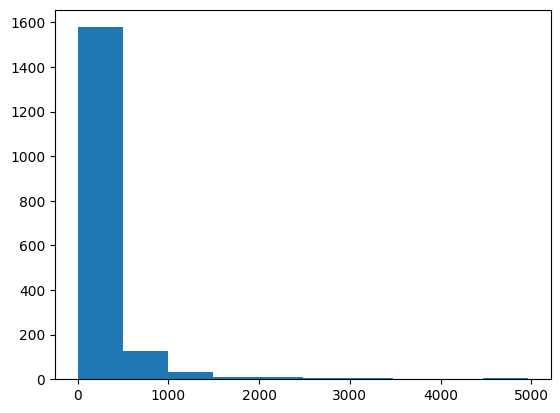

In [50]:
plt.hist(novo_df['price_var'])
plt.show()

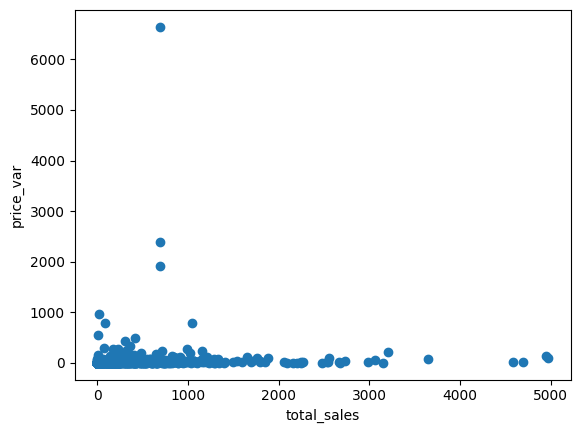

In [45]:
plt.scatter(novo_df['price_var'], novo_df['total_sales'])
plt.xlabel('total_sales')
plt.ylabel('price_var')
plt.show()

Plotting scatter plots of numer of occurences per day of a specific offer_option_id

In [ ]:
u = df1.loc[df1['offer_option_id'] == 2778975]['ingestion_time'].value_counts()
u = dict(u)
plt.plot(u.keys(),u.values(), label = '2778975')
plt.title('Number of occurrences per day offer_option_id = 2778975')
plt.ylabel('Number of occurrences')
plt.show()

In [ ]:
a = df1.loc[df1['offer_option_id'] == 2778975]
a

In [ ]:
a['to_datetime']= pd.to_datetime(a['ingestion_time'])

In [ ]:
a.head()

In [ ]:
max_delta(df1, 2778975)

In [ ]:
## Preciso calcular as diferecas entre os dias e se a diferenca é maior que 

In [ ]:
dates = []
for i in range(len(a)):
    o = pd.to_datetime(list(u.keys())[i])
    dates.append(o)
    deltas = np.diff(dates)
    #for i in range(len(dates)):
     #   if 

In [ ]:
type(a.iloc[0,0])

In [ ]:
t = a.groupby(pd.Grouper(key='to_datetime',freq ='1W')).sum()
t

In [ ]:
t.index

In [ ]:
t['sales']

In [ ]:
plt.plot(t.index,t['sales'], label = '2778975')
plt.title('Number of occurrences per day offer_option_id = 2778975')
plt.ylabel('Number of occurrences')
plt.show()

In [ ]:
pd.Grouper?

In [ ]:
deltas[0].days

In [ ]:
len(deltas)

In [ ]:
wind = 10 #window size in days
deltas_10 = []
for i in range(len(deltas)):
    if deltas[i].days>wind:
        deltas_10.append(deltas[i])

In [ ]:
len(deltas_10)

In [ ]:
len(a)

In [ ]:
y = df1.loc[df1['offer_option_id'] == 2778974]['ingestion_time'].value_counts()
y = dict(y)
plt.plot(y.keys(),y.values(), label = '2778974', color = 'g')
plt.title('Number of occurrences per day offer_option_id = 2778976')
plt.ylabel('Number of occurrences')
plt.show()

In [ ]:
z = df1.loc[df1['offer_option_id'] == 2778976]['ingestion_time'].value_counts()
z = dict(z)
plt.plot(z.keys(),z.values(), label = '2778976', color = 'r')
plt.title('Number of occurrences per day offer_option_id = 2778976')
plt.ylabel('Number of occurrences')
plt.show()

Trying to understand the biggest interval in days between two different offers of a given offer_option id.

In [ ]:
## Um detalhe aqui: a coluna das datas tem nomes diferentes nas diferentes versões do dataset. 
## Não sei se é sempre a primeira coluna. Por isso, essa funcao só funciona no v1.

In [140]:
def max_delta(df, offer_id):
    ######
    # Given a offer_option_id, that function that calculates the biggest interval in days 
    # between two different offers.
    #
    # df - pandas.Dataframe
    # offer_id - int
    ######
    e = df.loc[df['offer_option_id'] == offer_id]['ingestion_time'].value_counts().to_dict()
    dates = []
    for i in range(len(e)):
        o = pd.to_datetime(list(e.keys())[i])
        dates.append(o)
    deltas = np.diff(dates)
    if len(deltas)!= 0:
        max_delta = max(deltas).days
        print(f"The biggest interval between two offers with 'offer_option_id' = {offer_id} is {max_delta} days.")
    else:
        print(f"The biggest interval between two offers with 'offer_option_id' = {offer_id} is 0 days.")

In [141]:
max_delta(df1, 2778976)

The biggest interval between two offers with 'offer_option_id' = 2778976 is 269 days.


## Function that calculates extreme values of a given column and returns that package. Trying to answer extreme cases of sales or prices.

In [137]:
####
## Function that calculates extreme values of a given column and  returns that package.
## df = dataframe
## column = str
## hig = str
## Args:
## df: raw dataframe containing the data
## column: column whose extreme value is going to be calculated
## hig: minimun or maximum value
def ext_value(df, column, hig):
    if hig == 'max':
        hig_val = df[column].max()
        name = df.iloc[df[column].idxmax(),df.columns.get_loc('product_name')]
        print(f"The highest value of {column} is {hig_val} given by {name}.")
    else: 
        min_val = df[column].min()
        if min_val != 0:
            name = df.iloc[df[column].idxmin(),df.columns.get_loc('product_name')]
            print(f"The lowest value of {column} is {min_val} given by {name}.")
        else:  
            print(f"The lowest value of {column} is zero.")

In [139]:
ext_value(df2, 'sales', 'max')

The highest value of sales is 6429.0 given by Pacote de Viagem - Natal - All Inclusive - 2024.


In [138]:
ext_value(df1, 'sales', 'max')

The highest value of sales is 257.0 given by Pacote de Viagem - Porto Seguro + Resort All Inclusive - 2024.


In [ ]:
ext_value(df1, 'totalprice', 'min')

In [ ]:
ext_value(df1, 'totalprice', 'max')

In [ ]:
ext_value(df2, 'totalprice', 'max')

In [ ]:
ext_value(df2, 'totalprice', 'min')

In [ ]:
ext_value(df2, 'sales', 'min')

In [ ]:
ext_value(df2, 'sales', 'max')

##Find correlation in price conditioned in nac/int


In [5]:
df2.columns

Index(['ingestion_time', 'package_id', 'offer_option_id', 'sku',
       'discounted_price', 'package_clicks', 'offer_checkout', 'multidestino',
       'year', 'package_date_format', 'destination_city', 'destination_state',
       'destination_country', 'AttributeList', 'offer_option_title',
       'offer_option_description', 'product_name', 'qty_dailies',
       'option_cost', 'origin_city', 'all_inclusive_included_in_offer',
       'breakfast_included_in_offer', 'transfer_included_in_offer',
       'ticket_included_in_offer', 'tour_included_in_offer',
       'bus_included_in_offer', 'car_included_in_offer',
       'cruise_included_in_offer', 'destination_type', 'datebr', 'fullprice',
       'tax', 'discount', 'interest', 'totalprice', 'sales'],
      dtype='object')

In [6]:
df2_nac = df2[df2["destination_type"] == "NAC"]

In [8]:
df2_nac.head()

,ingestion_time,package_id,offer_option_id,sku,discounted_price,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,qty_dailies,option_cost,origin_city,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,destination_type,datebr,fullprice,tax,discount,interest,totalprice,sales
2,2022-01-07,1141944,2782951,LGPKG-1141944-2782951,1123,4903.0,8.0,False,2023.0,Data flexível,Gramado,Rio Grande do Sul,Brasil,"Café da manhã,Passagem Aérea Econômica,Hospedagem Econômica,Passeio",Aéreo de Cuiabá,Aéreo para Porto Alegre | Quarto Duplo ou Triplo | 5 Diárias (3 diárias em Caxias do Sul + 2 diárias em Gramado ou Canela) | Passeio a Casa Perini,Pacote de Viagem - Serra Gaúcha (Caxias do Sul + Gramado ou Canela) - 2023,5,1264,Cuiabá,False,True,False,False,True,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-07,1137691,2775414,LGPKG-1137691-2775414,498,NaN,12.0,False,2022.0,Data flexível,Belo Horizonte,Minas Gerais,Brasil,"Hospedagem Econômica,Café da manhã,Passagem Aérea Econômica",Aéreo do Rio de Janeiro - 2 diárias,Aéreo para Belo Horizonte | 2 Diárias em Quarto Duplo ou Triplo,Pacote de Viagem - Belo Horizonte (Minas Gerais) - 2022,2,375,Rio de Janeiro,False,True,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-07,1104605,2734845,LGPKG-1104605-2734845,2998,354.0,11.0,False,2022.0,Data flexível,Ilhéus,Bahia,Brasil,"Hospedagem Econômica,All inclusive,Passagem Aérea Econômica",Aéreo de São Paulo - 5 diárias,Aéreo para Ilhéus| 5 Diárias em Quarto Duplo ou Triplo.\r\n,Pacote de Viagem - Ilhéus - All Inclusive - 2022,5,2325,São Paulo,True,False,False,False,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2022-01-07,1138916,2777103,LGPKG-1138916-2777103,748,501.0,7.0,False,2023.0,Data flexível,Chapada dos Guimarães,Mato Grosso,Brasil,"Hospedagem Econômica,Café da manhã,Aluguel de carro,Passagem Aérea Econômica",Aéreo de São Paulo,Aéreo para Cuiabá | 4 diárias em quarto duplo ou triplo | Aluguel de carro,Pacote de Viagem - Chapada dos Guimarães - 2º Semestre 2023,4,1189,São Paulo,False,True,False,False,False,False,True,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2022-01-07,1142223,2783588,LGPKG-1142223-2783588,1311,712.0,4.0,False,2023.0,Data flexível,Fortaleza,Ceará,Brasil,"Hospedagem Econômica,Café da manhã,Ingresso",Aéreo de Belo Horizonte,Aéreo para Fortaleza | 4 Diárias em Quarto Duplo ou Triplo | Ingresso do Beach Park,Pacote de Viagem - Fortaleza + Beach Park - 2023 - taxas inclusas,4,899,Belo Horizonte,False,True,False,True,False,False,False,False,NAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
## Calculate correlation matrix of df2_nac

In [34]:
df2_nac_corr = df2_nac.corr()

/var/folders/zz/zyxvpxvq6csfxvn_n0000qnh0005xc/T/ipykernel_5915/922372716.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2_nac_corr = df2_nac.corr()


In [39]:
df2_nac_corr.index

Index(['package_id', 'offer_option_id', 'discounted_price', 'package_clicks',
       'offer_checkout', 'multidestino', 'year', 'qty_dailies', 'option_cost',
       'all_inclusive_included_in_offer', 'breakfast_included_in_offer',
       'transfer_included_in_offer', 'ticket_included_in_offer',
       'tour_included_in_offer', 'bus_included_in_offer',
       'car_included_in_offer', 'cruise_included_in_offer', 'fullprice', 'tax',
       'discount', 'interest', 'totalprice', 'sales'],
      dtype='object')

In [ ]:
## Negative correlation with sales: disc_price,fullprice, tax and interest, tax
## negative correlation with total price: package_clicks, offer_checkout
## negative correlation with offer_checkout: discount_price, option_cost, fullprice, tax, discount, mas é positiva com interest

In [45]:
df2_nac_corr['interest':]

,package_id,offer_option_id,discounted_price,package_clicks,offer_checkout,multidestino,year,qty_dailies,option_cost,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,fullprice,tax,discount,interest,totalprice,sales
interest,-0.034381,-0.037037,-0.041050,0.167198,0.198284,0.025828,0.033244,0.072082,-0.006890,0.083874,-0.074813,-0.011408,0.023624,0.020534,-0.029695,-0.031971,NaN,-0.041050,0.004081,0.004414,1.000000,0.142763,-0.032368
totalprice,0.015542,0.019881,0.871234,-0.121782,-0.113561,0.043570,-0.112537,0.309395,-0.007345,0.365570,-0.357125,0.065866,-0.072503,-0.086358,-0.097540,-0.106534,NaN,0.871234,0.545226,0.219102,0.142763,1.000000,-0.058977
sales,0.045404,0.045693,-0.017793,0.285577,0.476583,-0.009786,0.069001,0.013237,-0.003226,0.062060,-0.057926,-0.010801,-0.001727,-0.011421,-0.008544,-0.017060,NaN,-0.017793,-0.059164,0.037401,-0.032368,-0.058977,1.000000


In [40]:
df2_nac_corr

,package_id,offer_option_id,discounted_price,package_clicks,offer_checkout,multidestino,year,qty_dailies,option_cost,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,fullprice,tax,discount,interest,totalprice,sales
package_id,1.000000,0.995162,-0.000306,0.118396,0.090531,0.075548,0.610047,-0.164927,-0.045734,0.111787,-0.120898,-0.053305,-0.043601,-0.069618,0.197314,-0.124449,NaN,-0.044032,-0.032914,-0.141057,-0.034381,0.015542,0.045404
offer_option_id,0.995162,1.000000,-0.000193,0.116101,0.086368,0.072312,0.617809,-0.164565,-0.040425,0.119594,-0.138272,-0.051123,-0.039188,-0.069150,0.196943,-0.118554,NaN,-0.038500,-0.036585,-0.139868,-0.037037,0.019881,0.045693
discounted_price,-0.000306,-0.000193,1.000000,-0.035938,-0.070959,-0.003532,0.004882,-0.005027,0.144629,-0.000959,0.002442,-0.004014,-0.009016,-0.010155,-0.009151,-0.008573,NaN,1.000000,0.472976,0.623418,-0.041050,0.871234,-0.017793
package_clicks,0.118396,0.116101,-0.035938,1.000000,0.591091,-0.020425,0.138289,0.036150,-0.027718,0.169206,-0.153622,-0.067546,0.028062,0.002712,-0.050072,-0.050065,NaN,-0.111333,-0.124520,0.014304,0.167198,-0.121782,0.285577
offer_checkout,0.090531,0.086368,-0.070959,0.591091,1.000000,-0.011332,0.106491,0.017142,-0.026202,0.129871,-0.118507,-0.040788,0.049071,-0.003151,-0.034039,-0.051598,NaN,-0.149496,-0.064347,-0.053907,0.198284,-0.113561,0.476583
multidestino,0.075548,0.072312,-0.003532,-0.020425,-0.011332,1.000000,0.060395,0.287122,-0.025073,-0.060528,0.061972,-0.015665,-0.044496,0.056578,-0.032834,-0.049346,NaN,0.067171,0.046753,0.084059,0.025828,0.043570,-0.009786
year,0.610047,0.617809,0.004882,0.138289,0.106491,0.060395,1.000000,-0.026650,0.048762,0.048382,0.012845,-0.002318,0.056944,-0.022645,0.013776,0.023099,NaN,-0.056010,-0.085944,0.068954,0.033244,-0.112537,0.069001
qty_dailies,-0.164927,-0.164565,-0.005027,0.036150,0.017142,0.287122,-0.026650,1.000000,-0.053871,-0.010818,0.034202,-0.071677,-0.112851,0.082904,-0.184508,0.015774,NaN,0.334305,0.204721,0.222037,0.072082,0.309395,0.013237
option_cost,-0.045734,-0.040425,0.144629,-0.027718,-0.026202,-0.025073,0.048762,-0.053871,1.000000,-0.014640,0.021225,-0.021275,-0.037485,-0.048270,-0.030947,-0.028533,NaN,-0.007341,-0.035359,-0.016844,-0.006890,-0.007345,-0.003226
all_inclusive_included_in_offer,0.111787,0.119594,-0.000959,0.169206,0.129871,-0.060528,0.048382,-0.010818,-0.014640,1.000000,-0.899551,-0.050983,-0.072238,-0.091380,-0.040199,-0.060415,NaN,0.285687,0.118022,-0.005150,0.083874,0.365570,0.062060


In [24]:
df2_nac_corr.columns

Index(['package_id', 'offer_option_id', 'discounted_price', 'package_clicks',
       'offer_checkout', 'multidestino', 'year', 'qty_dailies', 'option_cost',
       'all_inclusive_included_in_offer', 'breakfast_included_in_offer',
       'transfer_included_in_offer', 'ticket_included_in_offer',
       'tour_included_in_offer', 'bus_included_in_offer',
       'car_included_in_offer', 'cruise_included_in_offer', 'fullprice', 'tax',
       'discount', 'interest', 'totalprice', 'sales'],
      dtype='object')

In [17]:
df2_int = df2[df2["destination_type"] == "INT"]

In [18]:
df2_int.head()

,ingestion_time,package_id,offer_option_id,sku,discounted_price,package_clicks,offer_checkout,multidestino,year,package_date_format,destination_city,destination_state,destination_country,AttributeList,offer_option_title,offer_option_description,product_name,qty_dailies,option_cost,origin_city,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,destination_type,datebr,fullprice,tax,discount,interest,totalprice,sales
0,2022-01-07,1138711,2776698,LGPKG-1138711-2776698,3536,2157.0,1.0,False,2023.0,Data flexível,Boedo,Buenos Aires,Argentina,"Jantar,Passagem Aérea Econômica,Hospedagem Econômica,Show",Aéreo de Brasília - 6 diárias,Aéreo para Buenos Aires | 6 diárias em quarto duplo ou triplo | Jantar com show de Tango,Pacote de Viagem - Buenos Aires + Jantar com Show de Tango - 2º Semestre 2023,6,3317,Brasília,False,False,False,False,False,False,False,False,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-07,1100870,2730806,LGPKG-1100870-2730806,7373,226.0,8.0,True,2022.0,Data flexível,Roma + Paris + Amsterdam,Lazio,Itália,"Hospedagem Econômica,Passagem Aérea Econômica",Aéreo de São Paulo - 6 diárias inclusas + 3 diárias GRÁTIS,Aéreo de ida e volta | Quarto Duplo ou Triplo | 9 Diárias (6 Diárias Inclusas + 1 Diária Grátis em Cada Destino) | 03 Diárias em Roma + 03 Diárias em Paris + 03 Diárias em Amsterdam.,Pacote de Viagem - Roma + Paris + Amsterdam com Diárias Grátis - 2022,9,5776,São Paulo,False,False,False,False,False,False,False,False,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2022-01-07,1132995,2768632,LGPKG-1132995-2768632,8311,28.0,NaN,False,2022.0,Data flexível,Dubrovnik,Dubrovnik-Neretva,Croácia,"Hospedagem,Passagem Aérea",Aéreo de São Paulo - 06 diárias,Aéreo para Dubrovnik | 06 Diárias em Quarto Duplo ou Triplo.,Pacote de Viagem - Croácia (Dubrovnik) - 2022,6,7219,São Paulo,False,False,False,False,False,False,False,False,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2022-01-07,1138404,2776312,LGPKG-1138404-2776312,3498,415.0,23.0,False,2023.0,Data flexível,Paris,Ilha de França,França,"Hospedagem Econômica,Jantar,Passagem Aérea Econômica,Passeio de barco",Aéreo de São Paulo - 06 diárias,Aéreo para Paris | 6 Diárias em Quarto Duplo ou Triplo | Cruzeiro no Rio Sena com Jantar Incluso.,Pacote de Viagem - Paris + Jantar em Cruzeiro no Rio Sena - 2º Semestre 2023,6,6966,São Paulo,False,False,False,False,False,False,False,False,INT,2022-01-07,3498.0,175.0,735.0,0.0,2938.0,2.0
12,2022-01-07,1095552,2723935,LGPKG-1095552-2723935,6424,401.0,17.0,False,2022.0,Data flexível,Nova Iorque,Nova Iorque,Estados Unidos,"Hospedagem Econômica,Passagem Aérea Econômica",Aéreo de São Paulo - 9 diárias,Aéreo para Nova Iorque | 9 Diárias em Quarto Duplo ou Triplo.,Pacote de Viagem - Nova Iorque - 2022,9,5035,São Paulo,False,False,False,False,False,False,False,False,INT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Things to make note about these matrix:
## 1.

In [19]:
df2_int.corr()

/var/folders/zz/zyxvpxvq6csfxvn_n0000qnh0005xc/T/ipykernel_5915/2189938168.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2_int.corr()


,package_id,offer_option_id,discounted_price,package_clicks,offer_checkout,multidestino,year,qty_dailies,option_cost,all_inclusive_included_in_offer,breakfast_included_in_offer,transfer_included_in_offer,ticket_included_in_offer,tour_included_in_offer,bus_included_in_offer,car_included_in_offer,cruise_included_in_offer,fullprice,tax,discount,interest,totalprice,sales
package_id,1.000000,0.993329,-0.007214,0.051784,0.013356,-0.057954,0.835771,-0.264868,0.217186,0.041063,-0.135072,-0.026447,0.102230,-0.106227,NaN,-0.198168,NaN,-0.025826,-0.198611,0.071334,0.045028,-0.120527,0.043187
offer_option_id,0.993329,1.000000,-0.008558,0.052357,0.012455,-0.054080,0.838086,-0.262097,0.216253,0.042978,-0.123354,-0.025792,0.098616,-0.103470,NaN,-0.208307,NaN,-0.013149,-0.202237,0.086241,0.045216,-0.116729,0.043864
discounted_price,-0.007214,-0.008558,1.000000,-0.009542,0.000404,-0.002981,-0.010072,0.027946,0.026138,0.000373,-0.013396,0.004608,-0.001674,-0.006055,NaN,0.000564,NaN,1.000000,0.449446,0.725673,0.043163,0.823168,-0.044884
package_clicks,0.051784,0.052357,-0.009542,1.000000,0.761899,-0.002790,0.120906,-0.010799,-0.008050,0.167650,-0.071494,-0.011873,-0.016263,-0.025451,NaN,-0.009755,NaN,-0.068148,-0.052106,0.022791,0.116669,-0.079338,0.257418
offer_checkout,0.013356,0.012455,0.000404,0.761899,1.000000,-0.000904,0.049792,-0.022081,-0.020460,0.082969,-0.035115,-0.007099,-0.010213,-0.011709,NaN,-0.005558,NaN,-0.089820,-0.021760,-0.021779,0.121102,-0.064478,0.292504
multidestino,-0.057954,-0.054080,-0.002981,-0.002790,-0.000904,1.000000,-0.060254,0.371677,0.103978,-0.198560,0.162060,-0.028960,-0.097359,-0.092663,NaN,0.158321,NaN,0.107213,0.106683,-0.025893,0.065549,0.197372,-0.017592
year,0.835771,0.838086,-0.010072,0.120906,0.049792,-0.060254,1.000000,-0.150266,0.277055,0.039872,-0.212326,-0.069968,0.057347,-0.094932,NaN,-0.128374,NaN,0.081057,-0.129814,0.269776,0.079346,-0.107506,0.067464
qty_dailies,-0.264868,-0.262097,0.027946,-0.010799,-0.022081,0.371677,-0.150266,1.000000,0.285074,-0.207037,0.037156,0.047537,-0.042825,-0.097937,NaN,0.071772,NaN,0.564623,0.184543,0.293542,0.083682,0.551012,-0.013148
option_cost,0.217186,0.216253,0.026138,-0.008050,-0.020460,0.103978,0.277055,0.285074,1.000000,-0.069264,-0.341110,0.023694,0.068411,0.047076,NaN,-0.030304,NaN,0.395249,0.160717,0.202690,0.049762,0.393002,0.004367
all_inclusive_included_in_offer,0.041063,0.042978,0.000373,0.167650,0.082969,-0.198560,0.039872,-0.207037,-0.069264,1.000000,-0.119576,-0.017134,-0.057602,-0.064782,NaN,-0.031436,NaN,0.137449,0.157755,0.262530,0.073217,0.036326,0.067346


In [ ]:
#colunas que nao quero 